Detecting and normalizing cycles
================================

The [cycles](api/kineticstoolkit.cycles.rst) module allows detecting cycles in TimeSeries, time-normalize these cycles and find the most repeatable ones.

In this tutorial, we will use kinetics data from wheelchair propulsion using a csv file.

In [1]:
import kineticstoolkit.lab as ktk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the instrumented wheel's csv file
filename = ktk.config.root_folder + '/data/pushrimkinetics/sample_sw_csvtxt.csv'

ts = ktk.pushrimkinetics.read_file(filename, file_format='smartwheel')
ts.data

{
       'Index': <array of shape (7777,)>
    'Channels': <array of shape (7777, 6)>
      'Forces': <array of shape (7777, 4)>
     'Moments': <array of shape (7777, 4)>
       'Angle': <array of shape (7777,)>
}

At this point, we have a TimeSeries that contains several signals, including forces and moments.

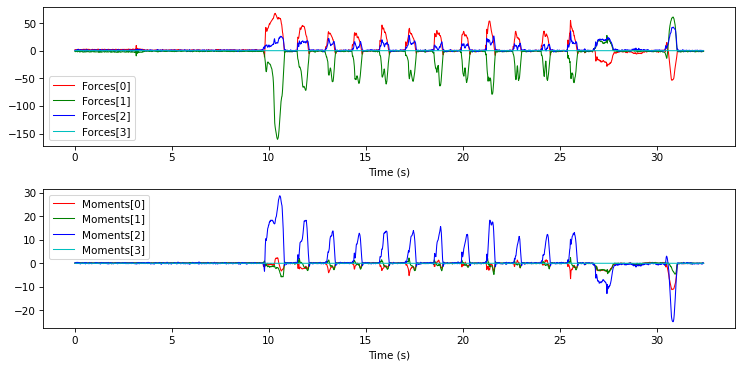

In [2]:
plt.subplot(2, 1, 1)
ts.plot('Forces')
plt.subplot(2, 1, 2)
ts.plot('Moments')
plt.tight_layout()

Detecting cycles
----------------

The [cycles.detect_cycles()](api/kineticstoolkit.cycles.detect_cycles.rst) function allows detecting cycles in a TimeSeries, using one specified signal from this TimeSeries. Here, this signal will be the total force Ftot.

We first calculate it based on the three force components and we add it as a new data of the TimeSeries.

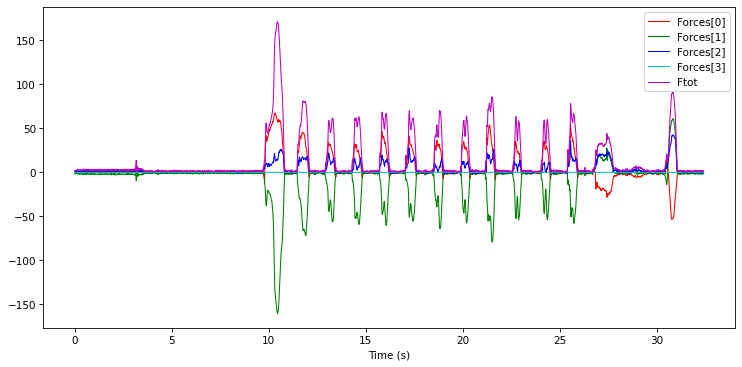

In [3]:
ts.data['Ftot'] = np.sqrt(np.sum(ts.data['Forces'] ** 2, 1))
ts.plot(['Forces', 'Ftot'])
plt.tight_layout()

Now let see how detecting cycles works. We will define the threshold values in Ftot visually based on the figure above.

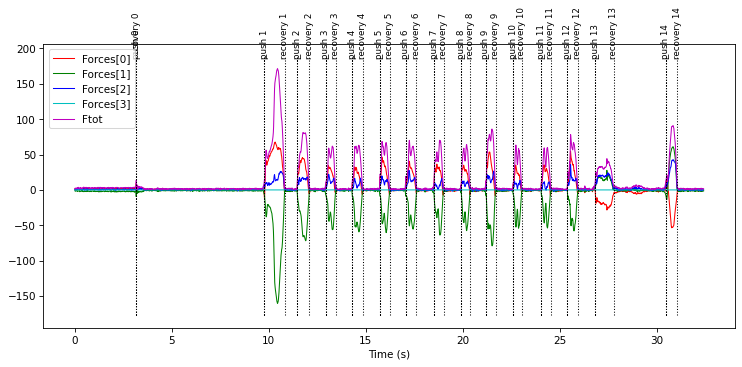

In [4]:
test = ktk.cycles.detect_cycles(ts, 'Ftot',
                                event_names=['push', 'recovery'],
                                thresholds=[10, 5])
test.plot(['Forces', 'Ftot'])
plt.tight_layout()

We observe that most cycles are well identified, but a short spike at the beginning was wrongly identified as a cycle. This in fact is not a cycle, but a synchronization spike used to sync data between many instruments. We can reject such too short "cycles" by specifying minimal durations for both phases.

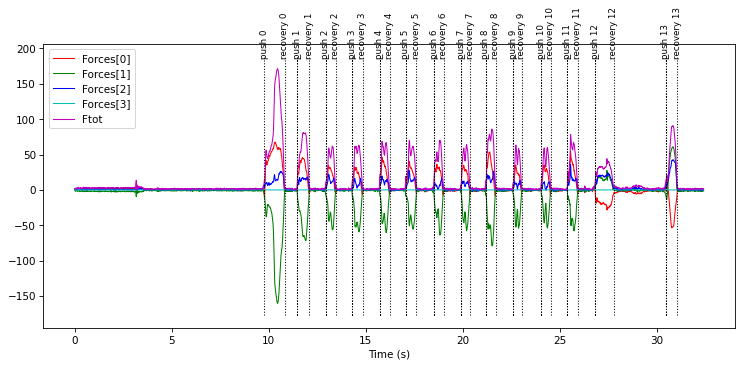

In [5]:
test = ktk.cycles.detect_cycles(ts, 'Ftot',
                                event_names=['push', 'recovery'],
                                thresholds=[10, 5],
                                min_durations=[0.2, 0.2])
test.plot(['Forces', 'Ftot'])
plt.tight_layout()

Now the synchronization spike has been ignored. However we also see that the two last cycles seem different: this is because they are braking pushes instead of propulsion pushes. While the last one will be difficult to remove automatically, we could remove the second-to-last by using a minimal peak value for the push phase.

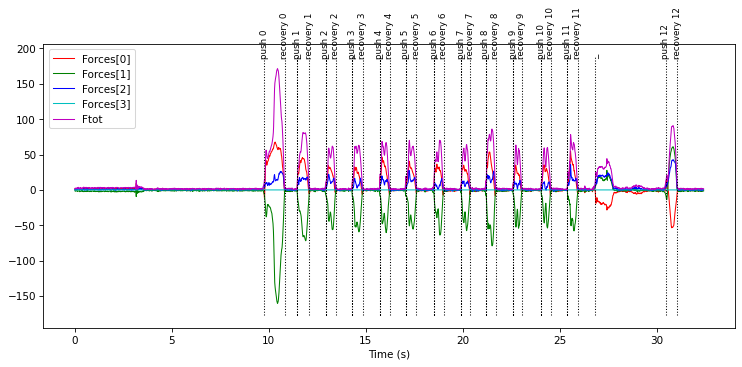

In [6]:
ts_with_events = ktk.cycles.detect_cycles(ts, 'Ftot',
                                          event_names=['push', 'recovery'],
                                          thresholds=[10, 5],
                                          min_durations=[0.2, 0.2],
                                          min_peak_heights=[50, -np.Inf])
ts_with_events.plot(['Forces', 'Ftot'])
plt.tight_layout()

We observe an `_` event at about 27 seconds. There are in fact such `_` events at the end of each cycle (look how each next push's 'p' letter seems underlined). This is because the `detect_cycles` function adds three events for each cycle:
- Beginning of phase 1: `event_name1`
- Transition from phase 1 to phase 2: `event_name2`
- Cycle end: `_`.

Time-normalizing cycles
-----------------------

Once the cycles have been detected, we can time-normalize these cycles using [cycles.time_normalize()](api/kineticstoolkit.cycles.time_normalize.rst) to get them on the same time scale (a percentage of the cycle). Each of the 12 complete cycles is then time-normalized from 0 to 100%, with cycles being multiples of 100%.

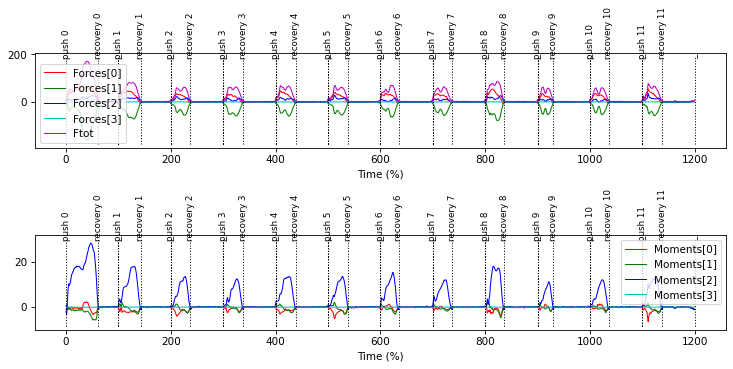

In [7]:
ts_normalized_on_cycle = ktk.cycles.time_normalize(ts_with_events, 'push', '_')
plt.subplot(2,1,1)
ts_normalized_on_cycle.plot(['Forces', 'Ftot'])
plt.subplot(2,1,2)
ts_normalized_on_cycle.plot('Moments')
plt.tight_layout()

To time-normalize only during the push phase, we define the cycle end as `recovery` instead of `_`. Each of the **13** complete pushes is then normalized from 0 to 100% of the push.

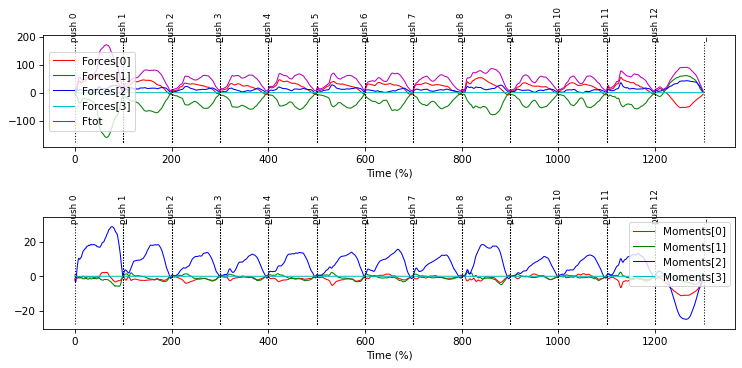

In [8]:
ts_normalized_on_push = ktk.cycles.time_normalize(ts_with_events, 'push', 'recovery')
plt.subplot(2,1,1)
ts_normalized_on_push.plot(['Forces', 'Ftot'])
plt.subplot(2,1,2)
ts_normalized_on_push.plot('Moments')
plt.tight_layout()

It is also possible to include data before 0% and after 100% using the `span` parameter. For example, to include pre-push and post-release data:

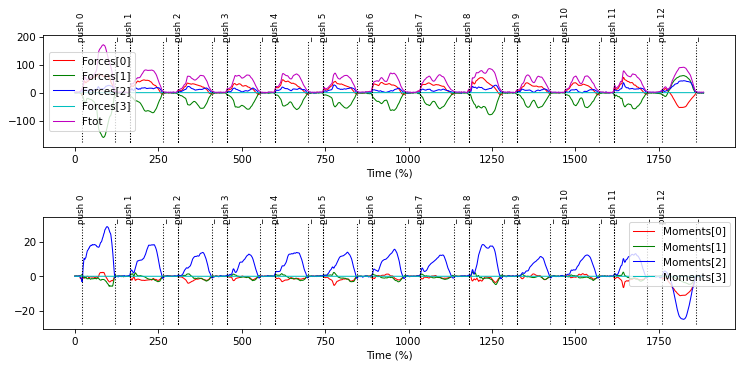

In [9]:
ts_normalized_on_push_with_span = ktk.cycles.time_normalize(ts_with_events, 'push', 'recovery', span=[-20, 125])
plt.subplot(2,1,1)
ts_normalized_on_push_with_span.plot(['Forces', 'Ftot'])
plt.subplot(2,1,2)
ts_normalized_on_push_with_span.plot('Moments')
plt.tight_layout()

Note that in this case, each time point represents 1% of a push cycle, but the TimeSeries wrap every 145 points (0 to 19 is the pre-push for the first cycle, 20 to 119 is the first push, 120 to 144 is the post-release for the first cycle, etc.).

Combining the cycles
--------------------
Time-normalizing cycles is often performed in the aim of performing further operations such as computing and visualizing the average cycle. Therefore, the next logical step is often to group the cycles into indexable arrays. This can be done using the [cycles.stack()](api/kineticstoolkit.cycles.stack.rst) function.

In this example, we will stack the data from the last computed TimeSeries.

In [10]:
data = ktk.cycles.stack(ts_normalized_on_push)
data

{
       'Index': <array of shape (13, 100)>
    'Channels': <array of shape (13, 100, 6)>
      'Forces': <array of shape (13, 100, 4)>
     'Moments': <array of shape (13, 100, 4)>
       'Angle': <array of shape (13, 100)>
        'Ftot': <array of shape (13, 100)>
}

The first dimension of each dictionary's entry corresponds to the cycles. It now becomes easier to perform operations on cycles. For example, we may want to plot the propulsive moment `Mz` (`Moments[2]`) in each cycle one of top of the other:

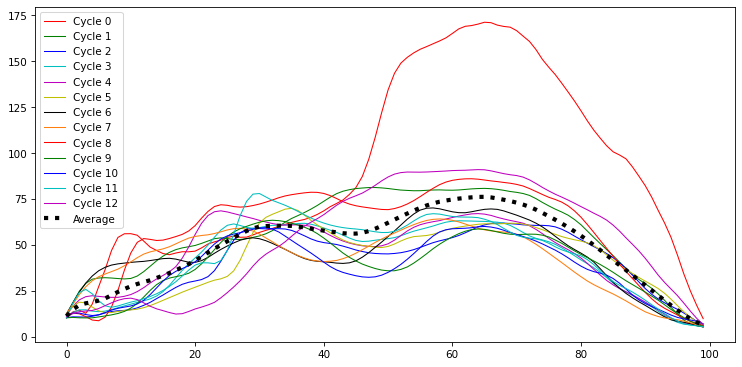

In [11]:
# Plot every cycles
for i_cycle in range(13):
    plt.plot(data['Ftot'][i_cycle], label=f"Cycle {i_cycle}")
    
# Plot the average cycle
plt.plot(
    np.mean(data['Ftot'], axis=0),
    'k:', linewidth=4, label="Average")

plt.legend()
plt.tight_layout()

Finding the most repeatable cycles
----------------------------------

In the previous step, we calculated an average cycle. However, this average cycle was calculated on cycles that were very different between each other. We can use the [cycles.most_repeatable_cycles()](api/kineticstoolkit.cycles.most_repeatable_cycles.rst) function to obtain an ordered list from the most repeatable cycles to the most different one. Here, we will base this analysis on the `Ftot` signal.

In [12]:
index = ktk.cycles.most_repeatable_cycles(data['Ftot'])
index                             

[9, 10, 2, 3, 5, 11, 4, 6, 7, 1, 8, 12, 0]

We see that cycles 12 (last) and 0 (first) were expectedly found as the least repeatable pushes since they are respectively a braking push and an acceleration push. Now let's make the same plot of `Mz`, but based only on the five most repeatable cycles.

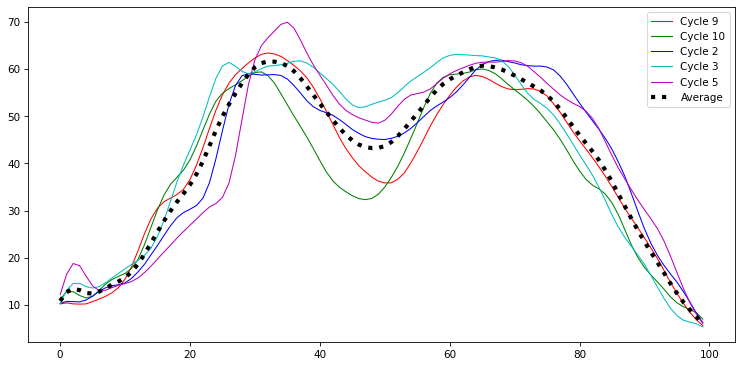

In [13]:
# Plot every cycles
for i_cycle in index[0:5]:
    plt.plot(data['Ftot'][i_cycle], label=f"Cycle {i_cycle}")
    
# Plot the average cycle
plt.plot(
    np.mean(data['Ftot'][index[0:5]], axis=0),
    'k:', linewidth=4, label="Average")

plt.legend()
plt.tight_layout()

For more information on cycles, please check the [API Reference for the cycles module](api/kineticstoolkit.cycles.rst).